<a href="https://colab.research.google.com/github/astrodeepnet/vae_mpoe/blob/main/VAE_LEGO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import tensorflow as tf
import keras
from keras import ops
from keras import layers

import numpy as np
import matplotlib.pyplot as plt

bands = [(0, 15), (15, 30), (30, 50), (50, 70), (70, 85), (85, 100)]

In [3]:
class Sampling(layers.Layer):

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.seed_generator = keras.random.SeedGenerator(1337)

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = ops.shape(z_mean)[0]
        dim = ops.shape(z_mean)[1]
        epsilon = keras.random.normal(shape=(batch, dim), seed=self.seed_generator)
        return z_mean + ops.exp(0.5 * z_log_var) * epsilon



In [4]:
def build_dense_encoder_sed_branch(input_shape):
    dense_input = keras.Input(shape=input_shape)
#    x = layers.Dense(64, activation='relu')(dense_input)
#    x = layers.Dense(32, activation='relu')(x)
    x = layers.Dense(32, activation='relu')(dense_input)
    x = layers.Dense(16, activation='relu')(x)
    return keras.Model(dense_input, x, name='dense_encoder_branch')

def build_dense_decoder_sed(latent_dim, output_dim):
    latent_inputs = keras.Input(shape=(latent_dim,), name=f'z_sampling')
    x = layers.Dense(16, activation='relu')(latent_inputs)
    x = layers.Dense(32, activation='relu')(x)
#    x = layers.Dense(64, activation='relu')(x)
    outputs = layers.Dense(output_dim, activation='sigmoid')(x)
    return keras.Model(latent_inputs, outputs, name='dense_decoder')

def build_encoder_sp_branch(input_shape):
    cnn_input = keras.Input(shape=input_shape)
    #x = layers.Conv1D(32, 3, activation='relu', strides=2, padding='same')(cnn_input)
    #x = layers.Conv1D(64, 3, activation='relu', strides=2, padding='same')(x)
    #x = layers.Conv1D(128, 3, activation='relu', strides=2, padding='same')(x)
    x = layers.Flatten()(cnn_input)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(64, activation='relu')(x)
    return keras.Model(cnn_input, x, name='cnn_encoder')

def build_dense_decoder_sp(latent_dim, output_dim):
    latent_inputs = layers.Input(shape=(latent_dim,), name='z_sampling')
    x = layers.Dense(16, activation='relu')(latent_inputs)
    x = layers.Dense(32, activation='relu')(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dense(128, activation='relu')(x)
    #x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(128, activation='relu')(x)
    #x = layers.Dense(256, activation='relu')(x)
    #x = layers.Dense(256, activation='relu')(x)
    x = layers.Dense(256, activation='relu')(x)
    outputs = layers.Dense(output_dim[0], activation='sigmoid')(x)
    #outputs = layers.Reshape(output_dim)(x)

    decoder = keras.Model(latent_inputs, outputs, name='dense_decoder')
    return decoder


In [5]:
def generate_spectrum(n_bins=100, n_peaks=3, noise_level=0.05, pmin=-1, pmax=1,):
    x = np.linspace(0, 1, n_bins)  # Avoid zero to prevent division by zero in power law
    spectrum = np.zeros_like(x)

    # Add power law component
    power_law_exponent = np.random.uniform(pmin, pmax)
    spectrum += np.power(x+0.3, power_law_exponent)

    # Add Gaussian peaks
    n = np.random.randint(1,n_peaks+1)
    for _ in range(n):
        amplitude_ = np.random.uniform(0.1, 1.0)
        mean = np.random.uniform(0.2, 0.8)
        std_dev = np.random.uniform(0.01, 0.1)
        amplitude = amplitude_ * spectrum[int(mean*n_bins)]
        spectrum += amplitude * np.exp(-0.5 * ((x - mean) / std_dev)**2)

    # Add noise
    noise = np.random.normal(scale=noise_level, size=n_bins)
    spectrum += noise
    params = [power_law_exponent, amplitude_, mean, std_dev]
    return x, params, spectrum

# Integrate the spectrum over given band passes
def integrate_band_passes(spectrum, band_edges):
    integrals = []
    for (start, end) in band_edges:
        band_val = np.nansum(spectrum[start:end]) / (end-start+1)
        integrals.append(band_val)
    return np.array(integrals)

# Generate a dataset
def generate_dataset(n_samples=1000, n_bins=100, n_peaks=3, noise_level=0.05, pmin=-1, pmax=1, band_edges=None):
    if band_edges is None:
        # Define 6 band pass edges (as indices for simplicity)
        band_edges = bands

    spectra = []
    integrals = []
    params = []

    for _ in range(n_samples):
        x, params_a, spectrum = generate_spectrum(n_bins=n_bins, n_peaks=n_peaks, noise_level=noise_level, pmin=pmin, pmax=pmax)
        #spectrum /= np.max(spectrum)
        spectra.append(spectrum)
        integrals.append(integrate_band_passes(spectrum, band_edges))
        params.append(params_a)

    spectra = np.array(spectra, dtype=np.float32)
    integrals = np.array(integrals, dtype=np.float32)
    params = np.array(params, dtype=np.float32)

    return spectra, integrals, params

# Normalize the spectra and integrals
def normalize(data):
    h = np.max(data, axis=1)[:,None]
    l = np.min(data, axis=1)[:,None]
    return data/h


In [6]:
def corner_plot(r, max_params):
    axs = tuple(range(min(max_params, r[0].shape[1])))  # Ensure indices do not exceed max dimensions
    fig, axes = plt.subplots(len(axs), len(axs), figsize=(10, 10))

    for i, ax_i in enumerate(axs):
        for j, ax_j in enumerate(axs):
            ax = axes[i, j]

            if i == j:
                # Diagonal: 1D histogram
                ax.hist(r[0][:, ax_i], bins=100, color='steelblue', alpha=0.7)
            elif i > j:
                # Lower triangle: 2D histogram
                ax.hist2d(r[0][:, ax_j], r[0][:, ax_i], bins=100, cmap='Blues')
            else:
                # Upper triangle: empty space
                ax.set_visible(False)

            # Remove ticks for clarity
            ax.set_xticks([])
            ax.set_yticks([])

    plt.tight_layout()


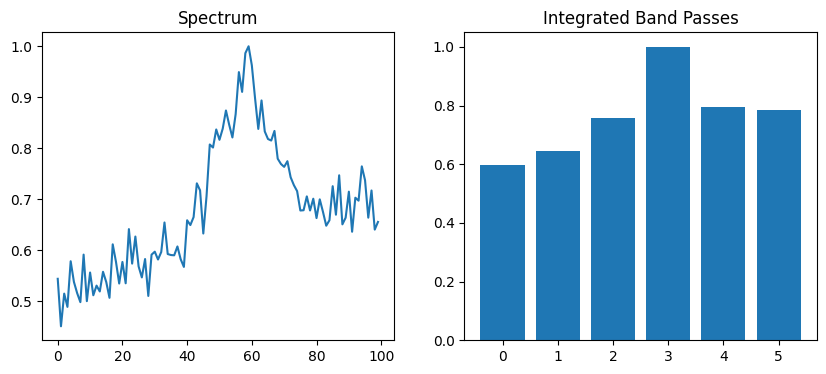

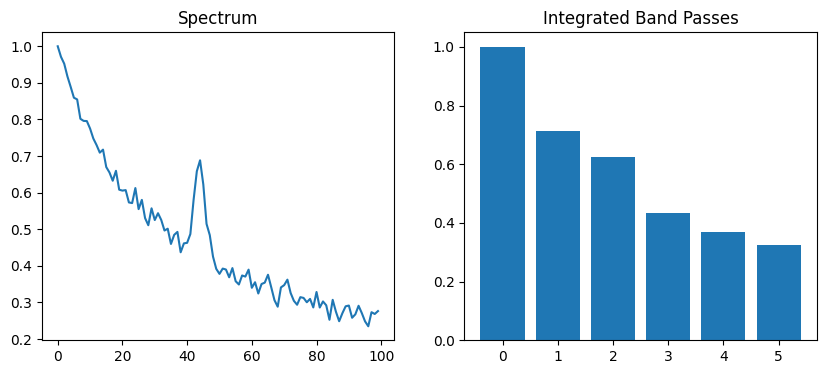

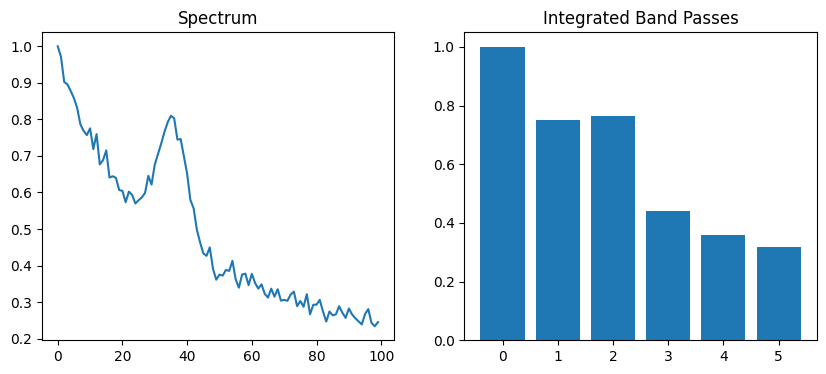

In [7]:
n_samples = 100000
n_bins = 100
n_peaks = 1
spectra, integrals, params = generate_dataset(n_samples, n_bins, n_peaks)
#spectra, integrals = generate_dataset(n_samples, n_bins, 1, noise_level=0, pmin=0)

# Normalize data
spectra = normalize(spectra)
integrals = normalize(integrals)

# Visualize some examples
for i in range(3):
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(spectra[i])
    plt.title('Spectrum')
    plt.subplot(1, 2, 2)
    plt.bar(range(len(integrals[i])), integrals[i])
    plt.title('Integrated Band Passes')
    plt.show()

In [8]:
class SpectraVAE(keras.Model):
    def __init__(self, input_dim, latent_dim, beta=1, **kwargs):
        super().__init__(**kwargs)
        self.encoder_branch = build_encoder_sp_branch((input_dim,1))

        self.z_mean = layers.Dense(latent_dim, name='z_mean')(self.encoder_branch.output)
        self.z_log_var = layers.Dense(latent_dim, name='z_log_var')(self.encoder_branch.output)

        self.z = Sampling()([self.z_mean, self.z_log_var])

        self.encoder = keras.Model(self.encoder_branch.inputs, [self.z_mean, self.z_log_var, self.z], name='cnn_encoder')

        self.decoder = build_dense_decoder_sp(latent_dim,(input_dim,1))
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        self.beta = beta
        #super().__init__(inputs=self.encoder.input, outputs=self.decoder.output, **kwargs)

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def apply(self, data):
        z_mean, z_log_var, z = self.encoder(data)
        reconstruction = self.decoder(z)
        return (z_mean, z_log_var, z, reconstruction)

    def call(self, data):
        return self.apply(data)[3]



    def train_step(self, data):
        with tf.GradientTape() as tape:
            (z_mean, z_log_var, z, reconstruction) = self.apply(data)
            reconstruction_loss = ops.mean(
                tf.keras.backend.mean(tf.keras.backend.square((data - reconstruction)/data))
            )
            kl_loss = -0.5 * (1 + z_log_var - ops.square(z_mean) - ops.exp(z_log_var))
            kl_loss = ops.mean(ops.sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss*self.beta
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
       }

    def test_step(self, data):
        (z_mean, z_log_var, z, reconstruction) = self.apply(data)
        reconstruction_loss = ops.mean(
                tf.keras.backend.mean(tf.keras.backend.square((data - reconstruction)/data))
        )
        kl_loss = -0.5 * (1 + z_log_var - ops.square(z_mean) - ops.exp(z_log_var))
        kl_loss = ops.mean(ops.sum(kl_loss, axis=1))
        total_loss = reconstruction_loss + kl_loss*self.beta
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

In [9]:
spvae = SpectraVAE(100, 16, beta=0.00001)
spvae.compile(optimizer=keras.optimizers.Adam())
hsp=spvae.fit(spectra, epochs=200, batch_size=128, validation_split=0.2)

Epoch 1/200


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(128, 100))
  warnings.warn(msg)


624/625 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - kl_loss: 61.2915 - loss: 0.0214 - reconstruction_loss: 0.0208

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 100))
  warnings.warn(msg)


625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - kl_loss: 61.3046 - loss: 0.0213 - reconstruction_loss: 0.0207 - val_kl_loss: 66.6947 - val_loss: 0.0130 - val_reconstruction_loss: 0.0124
Epoch 2/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - kl_loss: 68.4741 - loss: 0.0077 - reconstruction_loss: 0.0070 - val_kl_loss: 69.9038 - val_loss: 0.0056 - val_reconstruction_loss: 0.0049
Epoch 3/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - kl_loss: 65.5479 - loss: 0.0053 - reconstruction_loss: 0.0047 - val_kl_loss: 64.6582 - val_loss: 0.0048 - val_reconstruction_loss: 0.0041
Epoch 4/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - kl_loss: 62.6433 - loss: 0.0050 - reconstruction_loss: 0.0043 - val_kl_loss: 63.1979 - val_loss: 0.0046 - val_reconstruction_loss: 0.0040
Epoch 5/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - kl_loss: 60.7859 - loss: 0.0048 - reconstruction_loss: 0.0041 - val_kl_loss: 60.5015 - val_loss: 0.0045 - val_reconstruction_loss: 0.0039
Epoch 6/200
625/625 ━━━━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(10000, 100, 1))
  warnings.warn(msg)


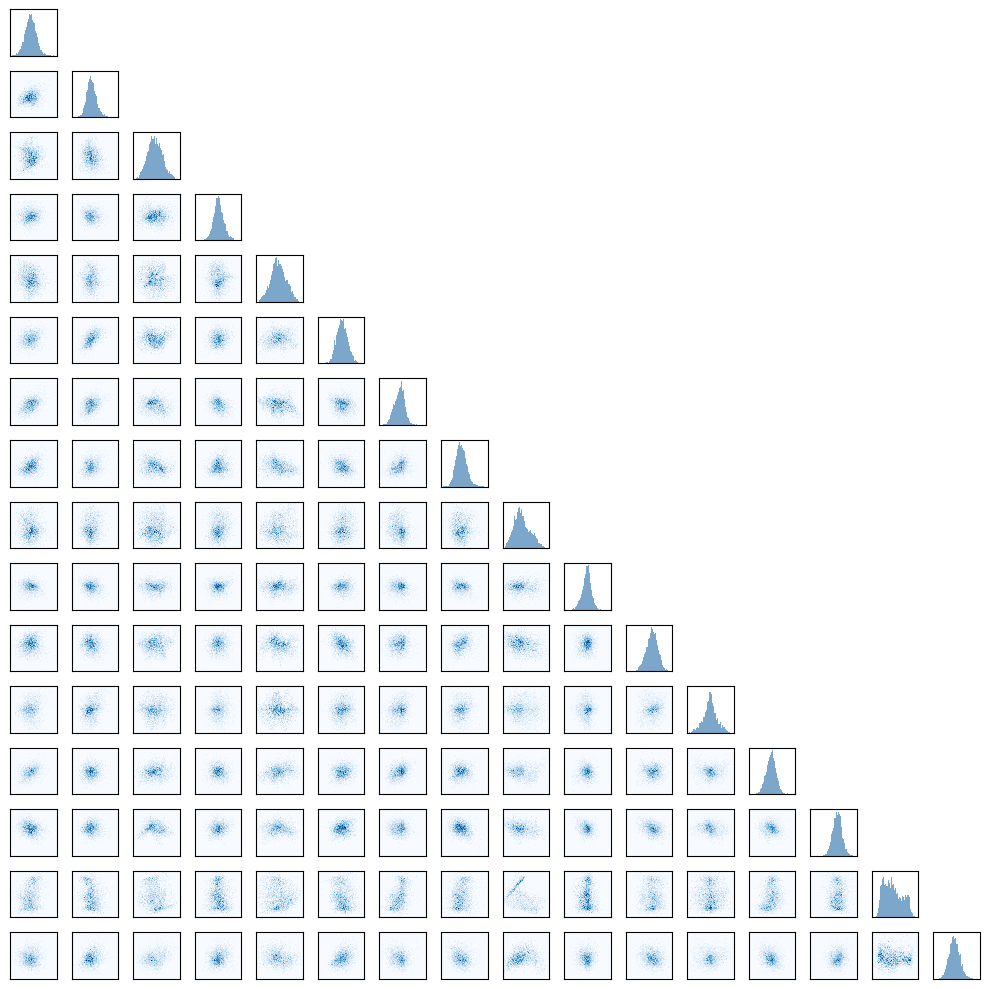

In [10]:
'''
ii = 150
N_smpl = 100
smpl_arr = []

ls_img_ =  spvae.encoder(np.reshape(spectra[ii], (1, 100)))

ls_img_ = np.array(ls_img_)

print(ls_img_)


for i in range(N_smpl):
    ls_img =  spvae.encoder(np.reshape(spectra[ii], (1, 100)))
    smpl_arr.append(ls_img[2])

smpl_arr = np.array(smpl_arr)

axs = (4, 5)

print(ls_img_[0, 0, axs[0]], ls_img_[1, 0, axs[0]])
print(ls_img_[0, 0, axs[1]], ls_img_[1, 0, axs[1]])


r = spvae.apply(np.reshape(spectra[:10000],(10000,100,1)))
plt.hist2d(r[0][:,axs[0]],r[0][:,axs[1]], bins=100)
plt.scatter(smpl_arr[:, 0, axs[0]], smpl_arr[:, 0, axs[1]], marker='+', color='red', linestyle='None')
'''

r = spvae.apply(np.reshape(spectra[:10000],(10000,100,1)))
corner_plot(r, max_params=16)



In [11]:
spvae.decoder

<Functional name=dense_decoder, built=True>

In [12]:
'''
!pip install corner
import corner
from itertools import combinations

# Fixed parameters
II = 10
N_SMPL = 10
MAX_AXS = 5  # User-defined maximum number of parameter combinations

# Encode spectrum
ls_img = spvae.encoder(np.reshape(spectra[II], (1, 100)))
print(ls_img)

# Sample encoding space
smpl_arr = np.array([
    spvae.encoder(np.reshape(spectra[II], (1, 100)))[2] for _ in range(N_SMPL)
])

# Reshape for plotting
smpl_arr = smpl_arr[:, 0, :]

# Apply model to dataset
r = spvae.apply(np.reshape(spectra[:10000], (10000, 100, 1)))
encoded_data = r[0]

# Generate all possible combinations of parameter indices
param_combinations = list(combinations(range(encoded_data.shape[1]), 2))[:MAX_AXS]

# Create corner plots for each combination
for axs in param_combinations:
    fig = corner.corner(encoded_data[:, list(axs)], labels=[f'Param {i}' for i in axs],
                         show_titles=True, plot_datapoints=True, hist2d=True)

    # Overlay sampled points
    for ax_idx, ax in enumerate(fig.axes):
        dim_x, dim_y = axs
        ax.plot(smpl_arr[:, dim_x], smpl_arr[:, dim_y], marker='+', color='red', linestyle='None')
'''

"\n!pip install corner\nimport corner\nfrom itertools import combinations\n\n# Fixed parameters\nII = 10\nN_SMPL = 10\nMAX_AXS = 5  # User-defined maximum number of parameter combinations\n\n# Encode spectrum\nls_img = spvae.encoder(np.reshape(spectra[II], (1, 100)))\nprint(ls_img)\n\n# Sample encoding space\nsmpl_arr = np.array([\n    spvae.encoder(np.reshape(spectra[II], (1, 100)))[2] for _ in range(N_SMPL)\n])\n\n# Reshape for plotting\nsmpl_arr = smpl_arr[:, 0, :]\n\n# Apply model to dataset\nr = spvae.apply(np.reshape(spectra[:10000], (10000, 100, 1)))\nencoded_data = r[0]\n\n# Generate all possible combinations of parameter indices\nparam_combinations = list(combinations(range(encoded_data.shape[1]), 2))[:MAX_AXS]\n\n# Create corner plots for each combination\nfor axs in param_combinations:\n    fig = corner.corner(encoded_data[:, list(axs)], labels=[f'Param {i}' for i in axs],\n                         show_titles=True, plot_datapoints=True, hist2d=True)\n\n    # Overlay sampled

In [13]:
class BandPassVAE(keras.Model):
    def __init__(self, input_dim, latent_dim, beta=1, **kwargs):
        super().__init__(**kwargs)
        self.encoder_branch = build_dense_encoder_sed_branch((input_dim,))

        self.z_mean = layers.Dense(latent_dim, name='z_mean')(self.encoder_branch.output)
        self.z_log_var = layers.Dense(latent_dim, name='z_log_var')(self.encoder_branch.output)

        self.z = Sampling()([self.z_mean, self.z_log_var])

        self.encoder = keras.Model(self.encoder_branch.inputs, [self.z_mean, self.z_log_var, self.z], name='dense_encoder')

        self.decoder = spvae.decoder
        self.decoder.trainable = False  # Prevent training of the decoder

        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        self.beta = beta
        #super().__init__(inputs=self.encoder.input, outputs=self.decoder.output, **kwargs)

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def apply(self, data):
        data_in = data
        z_mean, z_log_var, z = self.encoder(data_in)
        reconstruction = self.decoder(z)
        return (z_mean, z_log_var, z, reconstruction)

    def call(self, data):
        (data_in, data_out) = data[0]
        return self.apply(data_in)[3]

    def train_step(self, data):
        (data_in, data_out) = data[0]
        with tf.GradientTape() as tape:
            (z_mean, z_log_var, z, reconstruction) = self.apply(data_in)
            reconstruction_loss = ops.mean(
                    keras.losses.mean_squared_error(data_out, reconstruction),
            )
            kl_loss = -0.5 * (1 + z_log_var - ops.square(z_mean) - ops.exp(z_log_var))
            kl_loss = ops.mean(ops.sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss*self.beta
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
       }

    def test_step(self, data):
        print(data)
        (data_in, data_out) = data[0]
        (z_mean, z_log_var, z, reconstruction) = self.apply(data_in)
        reconstruction_loss = ops.mean(
                #keras.losses.mean_squared_error(data, reconstruction),
                tf.keras.backend.mean(tf.keras.backend.square((data_out - reconstruction)/data_out))
        )
        kl_loss = -0.5 * (1 + z_log_var - ops.square(z_mean) - ops.exp(z_log_var))
        kl_loss = ops.mean(ops.sum(kl_loss, axis=1))
        total_loss = reconstruction_loss + kl_loss*self.beta
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

    def call(self, data):
        data_in  = data
        z_mean, z_log_var, z = self.encoder(data_in)
        reconstruction = self.decoder(z)
        return reconstruction

In [14]:
bpvae = BandPassVAE(6,16, beta=0.0001)
bpvae.compile(optimizer=keras.optimizers.Adam())
h=bpvae.fit((integrals, spectra), epochs=200, batch_size=128, validation_split=0.2)


Epoch 1/200


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_15']
Received: inputs=Tensor(shape=(128, 6))
  warnings.warn(msg)


622/625 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - kl_loss: 7.3612 - loss: 0.0226 - reconstruction_loss: 0.0219((<tf.Tensor 'data:0' shape=(None, 6) dtype=float32>, <tf.Tensor 'data_1:0' shape=(None, 100) dtype=float32>),)


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_15']
Received: inputs=Tensor(shape=(None, 6))
  warnings.warn(msg)


625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - kl_loss: 7.3775 - loss: 0.0225 - reconstruction_loss: 0.0218 - val_kl_loss: 10.2295 - val_loss: 0.0317 - val_reconstruction_loss: 0.0307
Epoch 2/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - kl_loss: 10.4602 - loss: 0.0120 - reconstruction_loss: 0.0110 - val_kl_loss: 11.1680 - val_loss: 0.0273 - val_reconstruction_loss: 0.0262
Epoch 3/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - kl_loss: 11.2631 - loss: 0.0103 - reconstruction_loss: 0.0092 - val_kl_loss: 11.9776 - val_loss: 0.0199 - val_reconstruction_loss: 0.0187
Epoch 4/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - kl_loss: 11.3841 - loss: 0.0081 - reconstruction_loss: 0.0070 - val_kl_loss: 11.9240 - val_loss: 0.0157 - val_reconstruction_loss: 0.0145
Epoch 5/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - kl_loss: 11.2954 - loss: 0.0067 - reconstruction_loss: 0.0055 - val_kl_loss: 11.8883 - val_loss: 0.0123 - val_reconstruction_loss: 0.0112
Epoch 6/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_15']
Received: inputs=Tensor(shape=(1, 6))
  warnings.warn(msg)


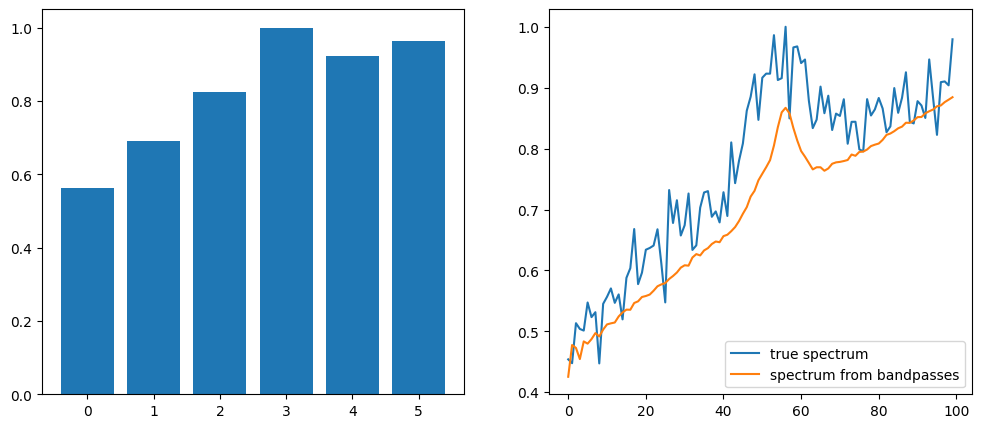

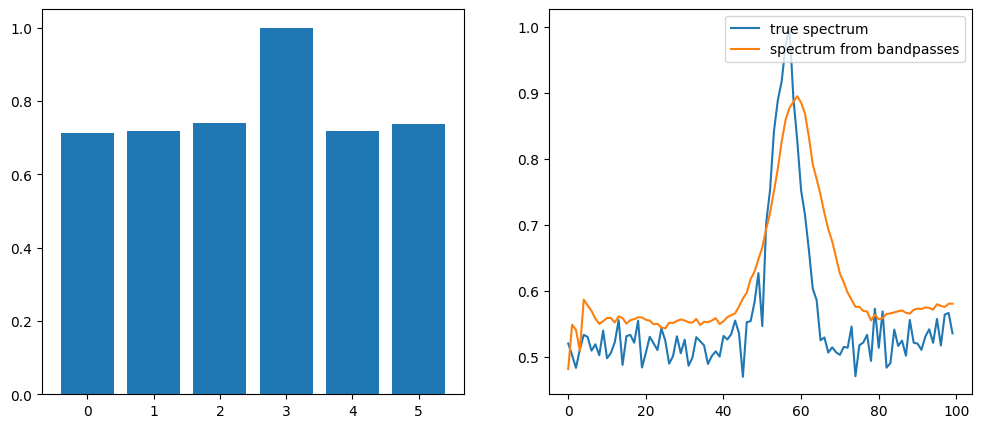

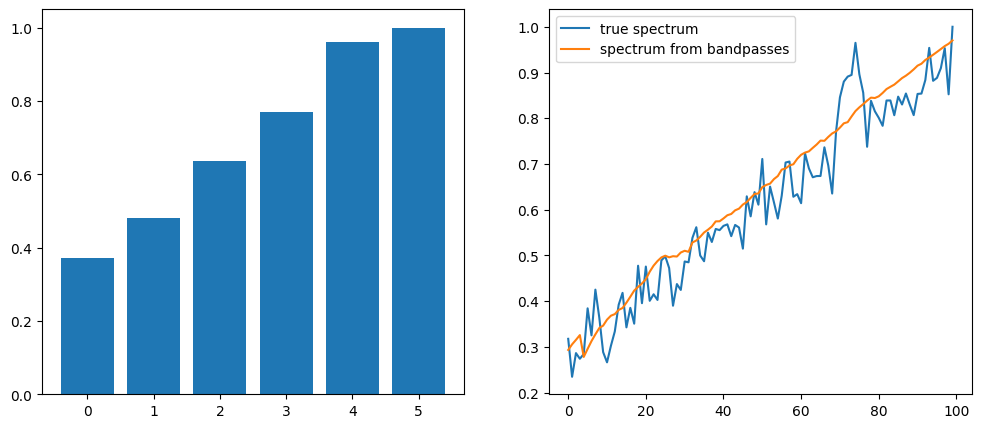

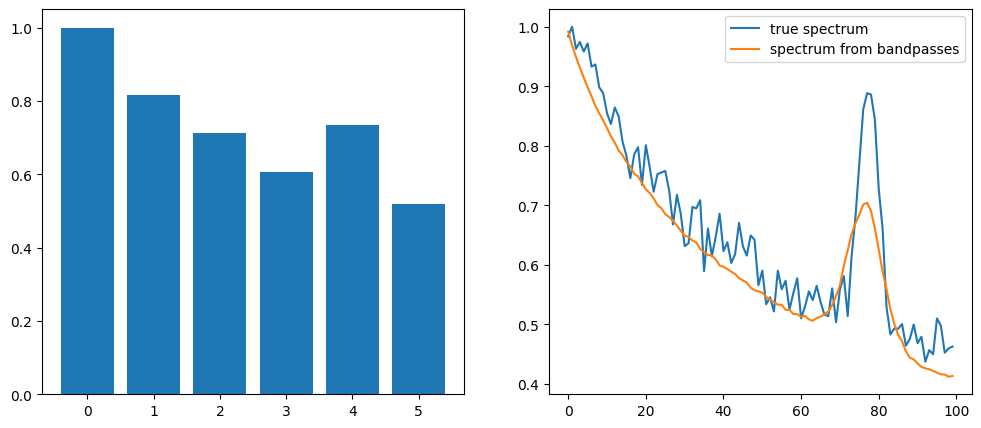

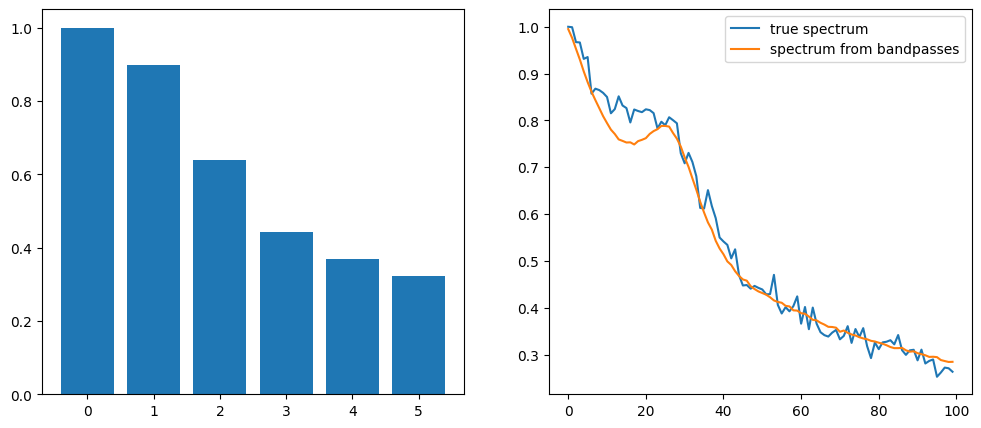

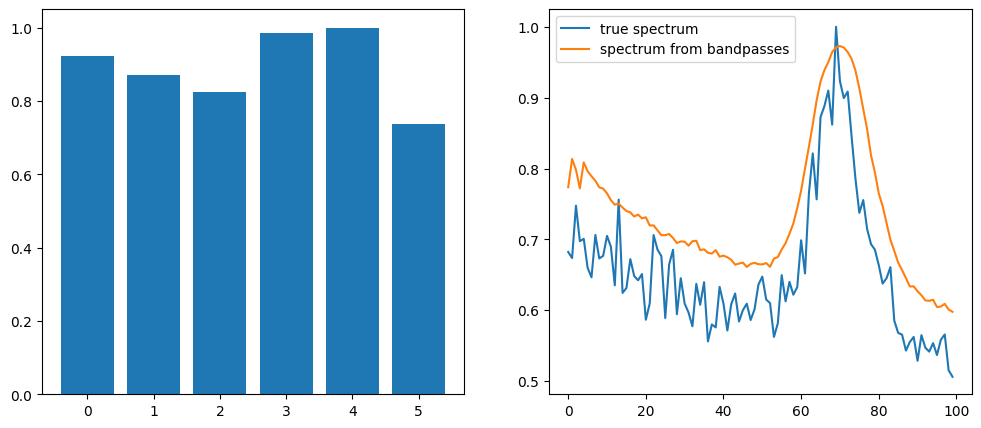

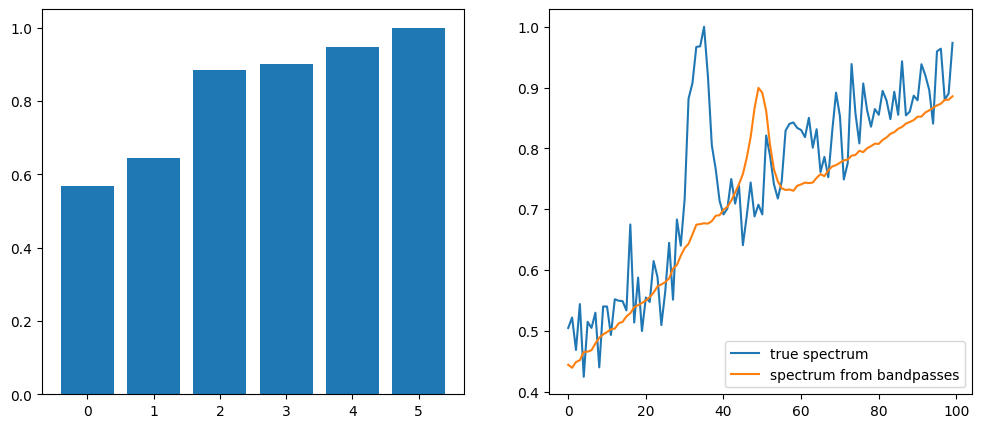

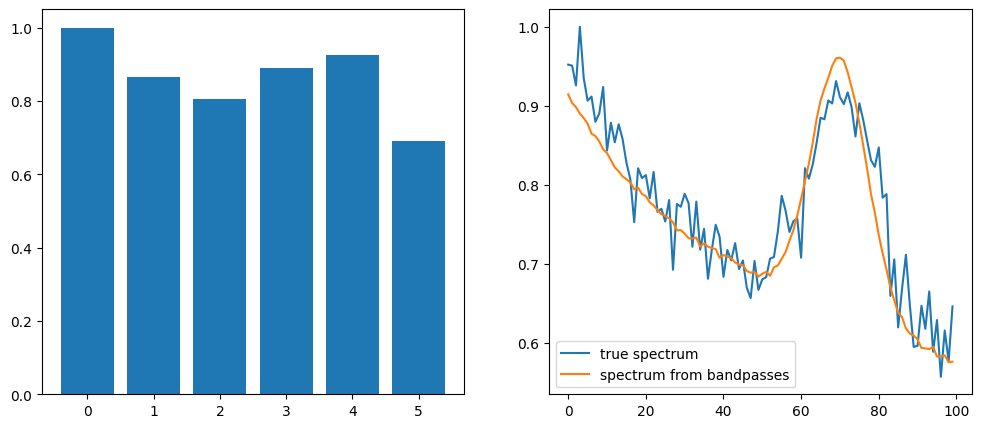

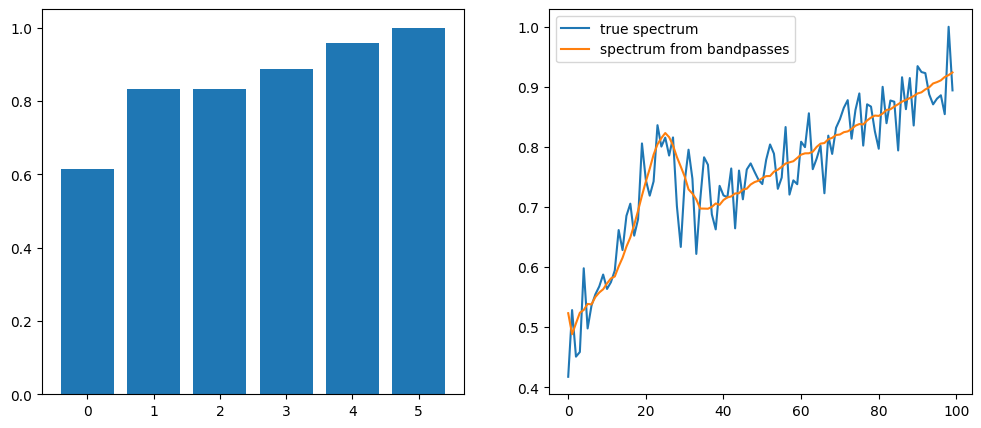

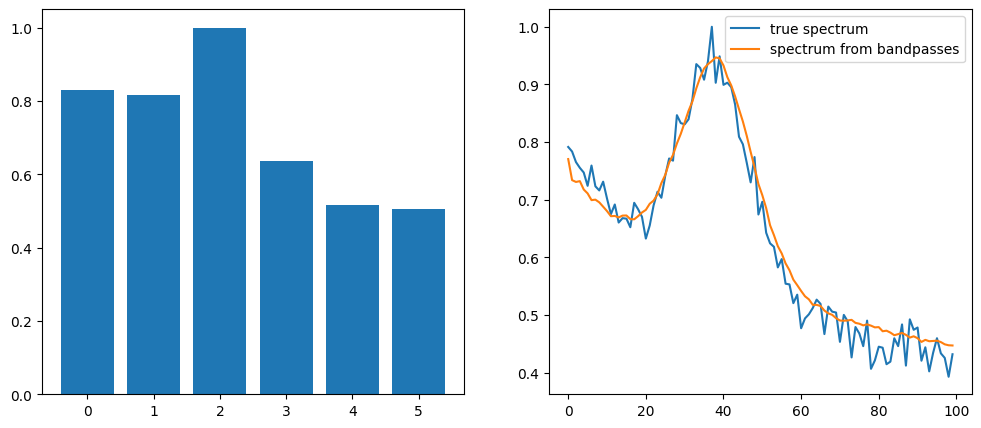

In [15]:
ii=1126
for ii in np.arange(ii, ii+10):
    fig, axs = plt.subplots(1, 2)
    fig.set_size_inches(12, 5)
    axs[1].plot(spectra[ii], label="true spectrum")
    s = bpvae(np.reshape(integrals[ii], (1,6)))
    s = np.reshape(s[0].numpy(),(100,))
    axs[1].plot(s, label="spectrum from bandpasses")
    axs[0].bar(range(len(integrals[ii])), integrals[ii])
    plt.legend()
    plt.show()

In [16]:
def build_dense_decoder_param(latent_dim, output_dim):
    latent_inputs = layers.Input(shape=(latent_dim,), name='z_sampling')
    x = layers.Dense(16, activation='relu')(latent_inputs)
    x = layers.Dense(32, activation='relu')(x)
    x = layers.Dense(32, activation='relu')(x)
    x = layers.Dense(32, activation='relu')(x)
    x = layers.Dense(32, activation='relu')(x)
    outputs = layers.Dense(output_dim[0])(x)

    decoder = keras.Model(latent_inputs, outputs, name='dense_decoder')
    return decoder


class ParamVAE(keras.Model):
    def __init__(self, input_dim, latent_dim, beta=1, **kwargs):
        super().__init__(**kwargs)
        self.encoder_branch = build_dense_encoder_sed_branch((input_dim,))

        self.z_mean = layers.Dense(latent_dim, name='z_mean')(self.encoder_branch.output)
        self.z_log_var = layers.Dense(latent_dim, name='z_log_var')(self.encoder_branch.output)

        self.z = Sampling()([self.z_mean, self.z_log_var])

        self.encoder = bpvae.encoder
        self.encoder.trainable = False  # Prevent training of the decoder

        self.decoder = build_dense_decoder_param(latent_dim,(4,1))
        self.decoder.trainable = True  # Prevent training of the decoder

        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        self.beta = beta
        #super().__init__(inputs=self.encoder.input, outputs=self.decoder.output, **kwargs)

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def apply(self, data):
        data_in = data
        z_mean, z_log_var, z = self.encoder(data_in)
        reconstruction = self.decoder(z)
        return (z_mean, z_log_var, z, reconstruction)

    def call(self, data):
        (data_in, data_out) = data[0]
        return self.apply(data_in)[3]

    def train_step(self, data):
        (data_in, data_out) = data[0]
        with tf.GradientTape() as tape:
            (z_mean, z_log_var, z, reconstruction) = self.apply(data_in)
            reconstruction_loss = ops.mean(
                tf.keras.backend.square(data_out - reconstruction)
            )
            kl_loss = -0.5 * (1 + z_log_var - ops.square(z_mean) - ops.exp(z_log_var))
            kl_loss = ops.mean(ops.sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss*self.beta
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
       }

    def test_step(self, data):
        print(data)
        (data_in, data_out) = data[0]
        (z_mean, z_log_var, z, reconstruction) = self.apply(data_in)
        reconstruction_loss = ops.mean(
                #keras.losses.mean_squared_error(data, reconstruction),
                tf.keras.backend.mean(tf.keras.backend.square(data_out - reconstruction))
        )
        kl_loss = -0.5 * (1 + z_log_var - ops.square(z_mean) - ops.exp(z_log_var))
        kl_loss = ops.mean(ops.sum(kl_loss, axis=1))
        total_loss = reconstruction_loss + kl_loss*self.beta
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

    def call(self, data):
        data_in  = data
        z_mean, z_log_var, z = self.encoder(data_in)
        reconstruction = self.decoder(z)
        return reconstruction

In [17]:
parvae = ParamVAE(6,16, beta=0.0001)
parvae.compile(optimizer=keras.optimizers.Adam())
h=parvae.fit((integrals, params), epochs=200, batch_size=128, validation_split=0.2)


Epoch 1/200


/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:774: UserWarning: Gradients do not exist for variables ['dense_12/kernel', 'dense_12/bias', 'dense_13/kernel', 'dense_13/bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


618/625 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - kl_loss: 11.3336 - loss: 0.0382 - reconstruction_loss: 0.0371((<tf.Tensor 'data:0' shape=(None, 6) dtype=float32>, <tf.Tensor 'data_1:0' shape=(None, 4) dtype=float32>),)
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - kl_loss: 11.3339 - loss: 0.0380 - reconstruction_loss: 0.0368 - val_kl_loss: 11.8592 - val_loss: 0.0120 - val_reconstruction_loss: 0.0108
Epoch 2/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - kl_loss: 11.3338 - loss: 0.0128 - reconstruction_loss: 0.0117 - val_kl_loss: 11.8592 - val_loss: 0.0089 - val_reconstruction_loss: 0.0077
Epoch 3/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - kl_loss: 11.3340 - loss: 0.0104 - reconstruction_loss: 0.0093 - val_kl_loss: 11.8592 - val_loss: 0.0078 - val_reconstruction_loss: 0.0066
Epoch 4/200
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - kl_loss: 11.3341 - loss: 0.0099 - reconstruction_loss: 0.0087 - val_kl_loss: 11.8592 - val_loss: 0.0077 - val_reconstruction_loss: 0.0065
Epoch 5/200
625/625 ━━━━━━

In [18]:
ii=1126
for ii in np.arange(ii, ii+20):
    s = parvae(np.reshape(integrals[ii], (1,6)))
    print(s, params[ii])


tf.Tensor([[0.38827723 0.38176948 0.5376719  0.04341212]], shape=(1, 4), dtype=float32) [0.42421514 0.22594336 0.5581472  0.08781858]
tf.Tensor([[0.07401952 0.76253366 0.58507246 0.03769702]], shape=(1, 4), dtype=float32) [0.02237554 0.8362867  0.5677154  0.03689458]
tf.Tensor([[0.8545383  0.23657681 0.5954982  0.02408856]], shape=(1, 4), dtype=float32) [0.8359866  0.22480193 0.7366126  0.0212551 ]
tf.Tensor([[-0.580421    0.6903732   0.77567875  0.0390612 ]], shape=(1, 4), dtype=float32) [-0.5551862   0.81020445  0.7806694   0.02633963]
tf.Tensor([[-0.88117373  0.44136024  0.26468325  0.06536301]], shape=(1, 4), dtype=float32) [-0.88971144  0.34705496  0.26405853  0.09581632]
tf.Tensor([[-0.17703901  0.6615591   0.69697917  0.06188525]], shape=(1, 4), dtype=float32) [-0.1849499   0.58620584  0.70109147  0.06276254]
tf.Tensor([[0.4312902  0.39951247 0.45082343 0.04029245]], shape=(1, 4), dtype=float32) [0.4877938  0.49215114 0.33969596 0.02470529]
tf.Tensor([[-0.27955472  0.5891722   0

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_15']
Received: inputs=Tensor(shape=(1000, 6))
  warnings.warn(msg)


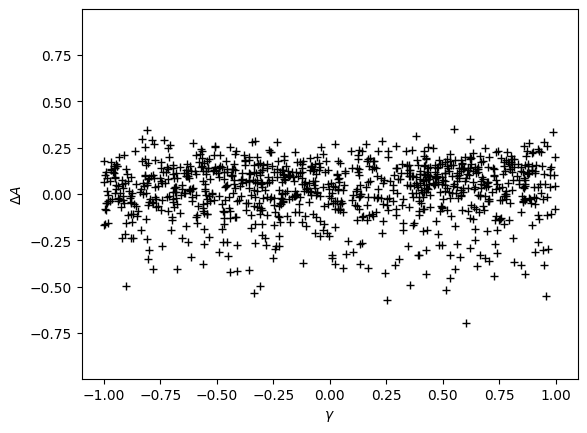

In [19]:
pnames = ['\gamma', 'A', '\mu', '\sigma']
s = parvae(np.reshape(integrals[1000:2000], (1000,6)))
p = params[1000:2000]
res = s - p

axs = (0, 1)


plx = p[:, axs[0]]
ply = res[:, axs[1]]
plt.plot(plx, ply, 'k+')
plt.ylim(-np.max(plx), np.max(plx))
plt.xlabel('$' + pnames[axs[0]] + '$')
plt.ylabel('$\Delta ' + pnames[axs[1]] + '$')
plt.show()
#plt.plot(p[:, 1], res[:, 1], 'k+')

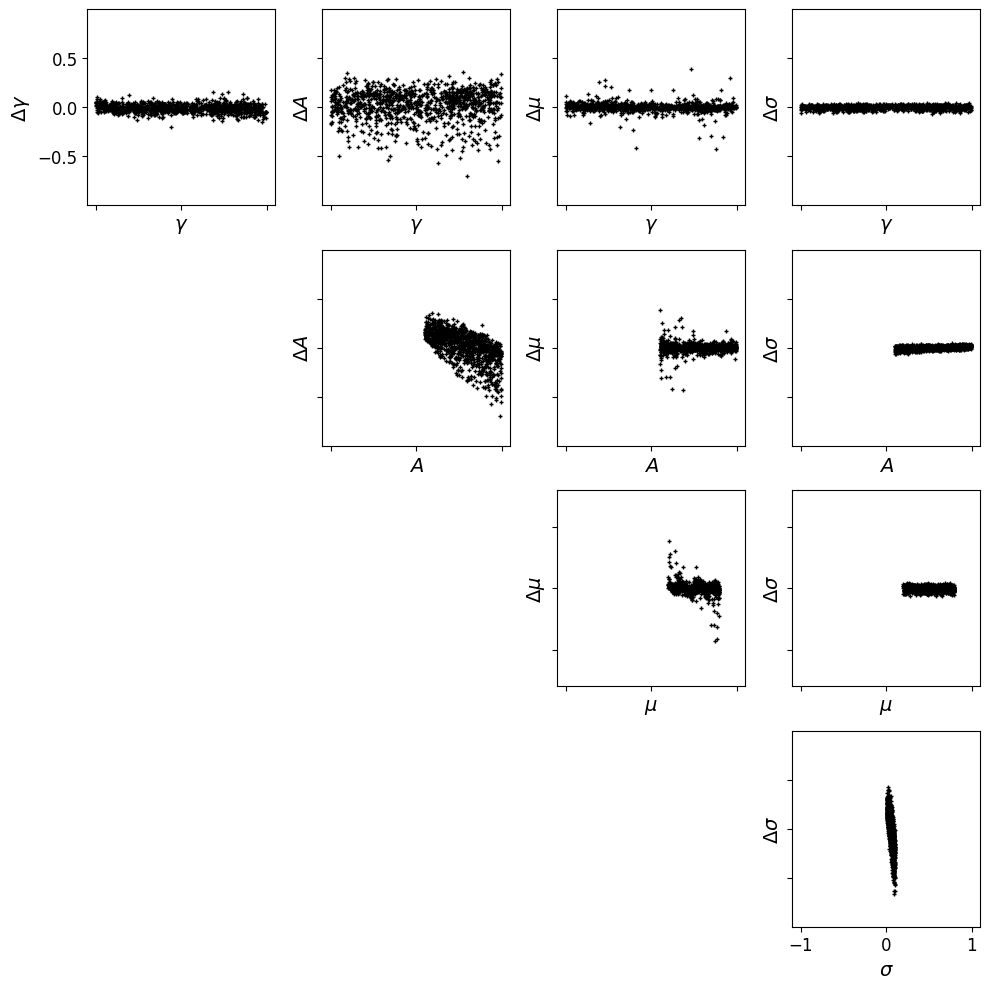

In [21]:
from itertools import combinations_with_replacement

def corner_plot_with_insets(p, res, N):
    """Generates a corner plot with insets for given parameter data and residuals."""
    pnames = ['\\gamma', 'A', '\\mu', '\\sigma']
    fig, axes = plt.subplots(N, N, figsize=(10, 10), sharex='col', sharey='row')

    for (i, j) in combinations_with_replacement(range(N), 2):
        ax = axes[i, j] if N > 2 else plt.gca()
        plx = p[:, i]
        ply = res[:, j]

        ax.plot(plx, ply, 'k+', markersize=3)
        ax.set_ylim(-np.max(plx), np.max(plx))
        ax.set_xlabel(f'${pnames[i]}$', fontsize=14)
        ax.set_ylabel(f'$\\Delta {pnames[j]}$', fontsize=14)
        ax.tick_params(axis='both', labelsize=12)

    # Remove empty subplots
    for i in range(N):
        for j in range(i):
            fig.delaxes(axes[i, j])

    plt.tight_layout()
    plt.show()



corner_plot_with_insets(p, res, 4)

[0.21670331 0.6454769  0.36634976 0.03360314]


<ipython-input-60-a8775a54b4ef>:27: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


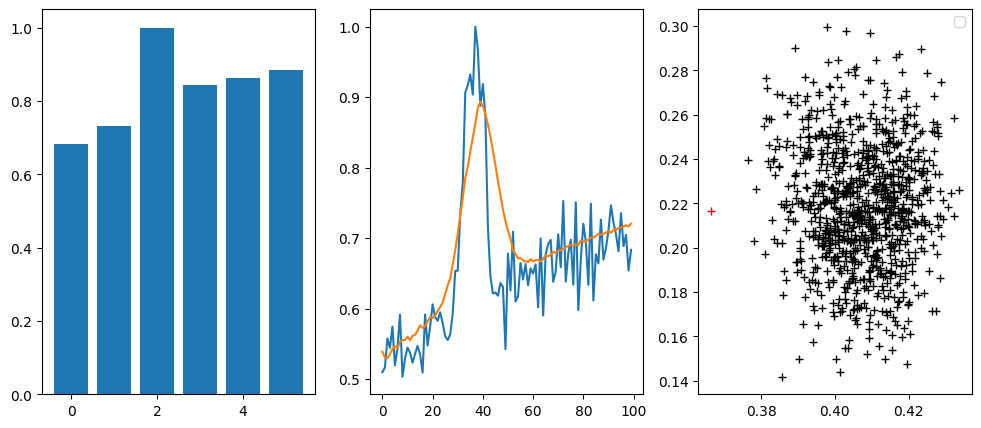

In [60]:
ii=10118
N_smpl = 1000
fig, axs = plt.subplots(1, 3)
fig.set_size_inches(12, 5)
axs[1].plot(spectra[ii], label="true spectrum")
s = bpvae(np.reshape(integrals[ii], (1,6)))
s = np.reshape(s[0].numpy(),(100,))

p = parvae(np.reshape(integrals[ii], (1,6)))
#p = np.reshape(s[0].numpy(),(4,))

smpl_latarr = []
for i in range(N_smpl):
    ls_img =  parvae.encoder(np.reshape(integrals[ii], (1,6)))
    smpl_latarr.append(ls_img[2])

smpl_latarr = np.array(smpl_latarr)

smpl_arr = parvae.decoder(np.reshape(smpl_latarr, (N_smpl,16)))

print(params[ii])

axs[1].plot(s, label="spectrum from bandpasses")
axs[0].bar(range(len(integrals[ii])), integrals[ii])
axs[2].plot(smpl_arr[:, 2], smpl_arr[:, 0], 'k+')
axs[2].plot(params[ii, 2], params[ii, 0], 'r+')
plt.legend()
plt.show()

